<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/gaig-layout-lm-v3/part_1_fine_tuning_layoutlmv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

**Reference**:

https://medium.com/@shivarama/layoutlmv3-from-zero-to-hero-part-3-16ae58291e9d

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets seqeval
!pip install accelerate -U

In [ ]:
!unzip layoutlmv3.zip

In [ ]:
import torch
import numpy as np
import pandas as pd

from  PIL import Image
from PIL import ImageDraw, ImageFont

from datasets import load_dataset
from datasets.features import ClassLabel
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from datasets import load_metric

from transformers import AutoProcessor
from transformers import LayoutLMv3ForTokenClassification
from transformers import TrainingArguments, Trainer
from transformers.data.data_collator import default_data_collator
from transformers import AutoModelForTokenClassification

## Load dataset

In [ ]:
# this dataset uses the new Image feature :)
dataset = load_dataset("./layoutlmv3.py", trust_remote_code=True)

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/utils/file_utils.py:1491: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


["{'id': 22, 'file_name': 'a6c337a6-0000226847.png', 'tokens': ['BEI', 'Ne', '013,', '13,950'], 'bboxes': [[457, 247, 476, 254], [483, 247, 493, 255], [512, 249, 542, 258], [556, 302, 598, 314]], 'ner_tags': [0, 0, 0, 2]}", "{'id': 0, 'file_name': '16d25098-0000037007.png', 'tokens': ['$-371-0451', '905-371-9801', '$275.28', '3/29/78'], 'bboxes': [[35, 105, 107, 114], [126, 105, 216, 115], [550, 490, 610, 500], [608, 129, 669, 146]], 'ner_tags': [0, 0, 2, 1]}", "{'id': 6, 'file_name': 'a101d866-0000113778.png', 'tokens': ['#1809', 'January', '19,', '1980'], 'bboxes': [[548, 117, 590, 130], [376, 169, 437, 184], [446, 172, 467, 184], [481, 171, 512, 185]], 'ner_tags': [0, 1, 1, 1]}", "{'id': 24, 'file_name': '289b7d8b-0000227918.png', 'tokens': ['MFEND:', '3399', '$34,440.00', 'oe.', 'saps'], 'bboxes': [[442, 402, 484, 410], [498, 402, 528, 412], [531, 479, 611, 499], [441, 348, 466, 358], [498, 351, 559, 363]], 'ner_tags': [0, 0, 2, 1, 1]}", "{'id': 12, 'file_name': '647d97ee-000014592

Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/utils/file_utils.py:1491: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


["{'id': 1, 'file_name': '4d9582bd-0000037010.png', 'tokens': ['05.971-0981', '309-971-401', '3432.00'], 'bboxes': [[82, 164, 142, 172], [156, 165, 222, 172], [477, 491, 522, 499]], 'ner_tags': [0, 0, 2]}", "{'id': 18, 'file_name': '45cdee5d-0000225942.png', 'tokens': ['prin', 'gygg', '$13,650.90', '4', 'Date:', '12/26/77'], 'bboxes': [[452, 342, 490, 351], [508, 335, 547, 358], [536, 461, 613, 472], [496, 281, 514, 285], [451, 287, 476, 297], [514, 293, 575, 305]], 'ner_tags': [0, 0, 2, 1, 1, 1]}", "{'id': 13, 'file_name': '46252a07-0000164590.png', 'tokens': ['3370', 'December', '13,', '1978'], 'bboxes': [[424, 153, 453, 163], [422, 101, 484, 110], [495, 101, 514, 112], [525, 100, 554, 110]], 'ner_tags': [0, 1, 1, 1]}", '{\'id\': 5, \'file_name\': \'7df25274-0000113760.png\', \'tokens\': [\'ween\', \'19ty,\', \'$391.89\', \'ome\', "Sune\'22,", \'19°3\'], \'bboxes\': [[289, 135, 337, 142], [351, 134, 379, 144], [479, 481, 548, 491], [90, 136, 107, 144], [126, 135, 182, 147], [194, 135

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 12
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 8
    })
})

In [ ]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['invoice_no', 'date', 'amount'], id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None)}

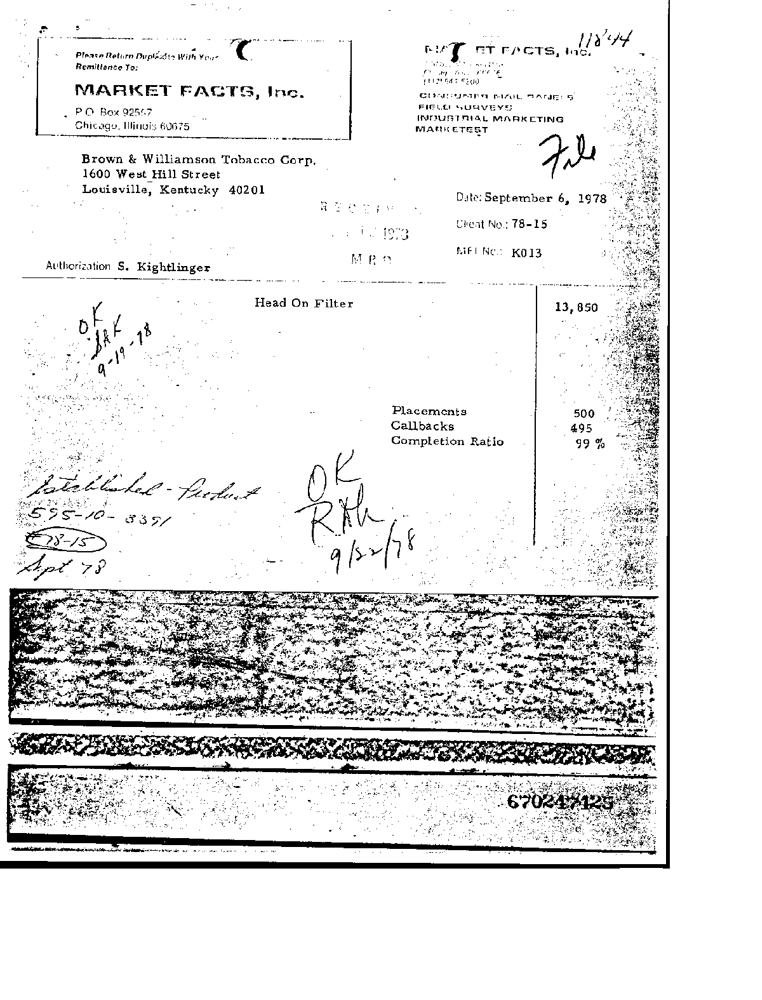

In [ ]:
# Inspect one of the annotated images
example = dataset["train"][0]
example["image"]

In [ ]:
sample_img = example["image"].convert("RGB")
sample_img.size

(762, 1000)

In [ ]:
sample_img = Image.open(r"/content/layoutlmv3/0e24fae4-0000227351.png").convert("RGB")
sample_img.size

(762, 1000)

In [ ]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['BEI', 'Ne', '013,', '13,950']
[[599, 247, 624, 254], [633, 247, 646, 255], [671, 249, 711, 258], [729, 302, 784, 314]]
[0, 0, 0, 2]


## Load Tokenizer

In [ ]:
# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [ ]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

In [ ]:
# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label

In [ ]:
if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [ ]:
print(label_list)

['invoice_no', 'date', 'amount']


In [ ]:
print(id2label)

{0: 'invoice_no', 1: 'date', 2: 'amount'}


## Tokenize dataset

In [ ]:
def prepare_example(examples):
    images = examples[image_column_name]
    words = examples[text_column_name]
    boxes = examples[boxes_column_name]
    word_labels = examples[label_column_name]

    encoding = processor(
        images, words, boxes=boxes, word_labels=word_labels,
        padding="max_length",
        truncation=True
    )
    return encoding

In [ ]:
# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_example,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_example,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 12
})

In [ ]:
example = train_dataset[0]
processor.tokenizer.decode(example['input_ids'])

'<s> BEI Ne 013, 13,950</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [ ]:
train_dataset.set_format("torch")

In [ ]:
example = train_dataset[0]
for k, v in example.items():
  print(f"{k}\t >> {v.shape}")

pixel_values	 >> torch.Size([3, 224, 224])
input_ids	 >> torch.Size([512])
attention_mask	 >> torch.Size([512])
bbox	 >> torch.Size([512, 4])
labels	 >> torch.Size([512])


In [ ]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 8
})

In [ ]:
processor.tokenizer.decode(eval_dataset[0]['input_ids'])

'<s> 05.971-0981 309-971-401 3432.00</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [ ]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

## Load Model

In [ ]:
metric = load_metric("seqeval")

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [ ]:
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

In [ ]:
training_args = TrainingArguments(
    output_dir="./test",
    max_steps=1000,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-5,
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [ ]:
# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator,
    tokenizer=processor,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1102: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
